## TODO: For now we only segment the liver
- Use weighted Cross Entropy for now
- ~~train with one patch only (try to overfit on 1 single patch), loss should go to zero~~ for testing dice
- Run it on an image and look at the segmentation that it generates.
- Debug Dice loss function (verify that it does what you think it does), **added what to change in comments**

**Stuff for later:**
- Write function to run it on all images, output dice per scan and avg dice. Which images work well and which don’t?
- Connected component post-processing.
- Note that image with index 37 of the test set has other dimensions.

Inspiration for improvements: **nnU-Net: Self-adapting Framework
for U-Net-Based Medical Image Segmentation** (https://arxiv.org/pdf/1809.10486.pdf)

In [1]:
# imports
import matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import json
import warnings
from random import randint
import random
import SimpleITK as sitk
from multi_slice_viewer import multi_slice_viewer
from IPython.display import clear_output
import pickle 
from tqdm import tqdm_notebook as tqdm
import warnings
import h5py
import ipywidgets
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv3D, MaxPooling3D, Dropout, Conv3DTranspose, UpSampling3D, concatenate, Cropping3D, Reshape, BatchNormalization
import keras.callbacks
from keras import backend as K
from keras import optimizers
from keras import regularizers
from keras import initializers
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from tensorflow.python.client import device_lib
from keras.utils import multi_gpu_model

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [2]:
# check if we use gpu or cpu
print(device_lib.list_local_devices())
print(tf.test.is_gpu_available())
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13844993444750747712
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3566305388058873856
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1746456890211457053
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14649627923526506796
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322644890
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14518894369997936032
physical_device_desc: "device: 0, name: Tesla K40m, pci bus id: 0000:03:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11322644890
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnat

In [3]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
assert len(K.tensorflow_backend._get_available_gpus()) > 0

In [4]:
# Task03_liver dir in same directory as notebook
data_path = './Task03_Liver/'

In [5]:
# info about dataset in json file
with open(data_path + 'dataset.json') as f:
    d = json.load(f)   
    
    # paths to training set images with label
    train_paths = d['training']
    
    # paths to testset images with label
    test_paths = d['test'] 

In [6]:
# change to data dir 
os.chdir(data_path)
print(os.getcwd())

/nfs/home3/hesterh/ISMI_project/Task03_Liver


# Load the train set and test set as SITK images

In [7]:
# paths to files
train_imgs = [train_instance['image'] for train_instance in train_paths]
train_lbls = [train_instance['label'] for train_instance in train_paths]
# test_imgs  = [test_instance for test_instance in test_paths]

## Resampling
Images do not have the same spacings. We will first resample. For this we need the spacings in the SITK images. Note that when converting sitk to numpy the z axis is placed at the front. Spacings in order: (x, y, z), numpy image: (z, x, y)

Resample to 1mm x 1mm x 1mm resolution => images should have different sizes (not all 512 x 512 x N anymore). 
For example, when the image has a shape of (512, 512, 74) and a spacing of (0.75, 0.75, 2),
you can calculate how wide the image is along the x-axis: 512 * 0.75 mm = 384 mm. As a tip, look for “scipy zoom”.

In [8]:
# now load one image and label at a time
def resample_and_save(paths, order, filename):     
    print('Storing resampled dataset at {}.'.format(os.path.join(os.getcwd(), filename)))    
    
    # make a h5py file to store images as numpy in
    with h5py.File(filename, 'w') as f: 
        for i, path in enumerate(tqdm(paths)):            
            
            # read the image
            img = sitk.ReadImage(path)
            
            # get the spacing
            spacing = img.GetSpacing()
            
            # change order
            x, y, z = spacing            
            spacing = (z, x, y)      # order: (z, x, y)

            # convert to numpy
            np_img = sitk.GetArrayFromImage(img)

            # apply zoom
            np_img_re = zoom(np_img, spacing, order=order)
            
#             print("Index: {}, Before: {}, after: {}".format(i, np_img.shape, np_img_re.shape))

            # save the resamples img/label
            dataset = f.create_dataset(str(i), data=np_img_re)      

In [ ]:
# use order 3 interpolation for imgs, order 0 for labels
resample_and_save(train_imgs, order=3, filename='resampled_train_imgs.h5py')
#resample_and_save(train_lbls, order=0, filename='resampled_train_lbls.h5py')
#resample_and_save(test_imgs, order=3, filename='resampled_test_imgs.h5py')

Storing resampled dataset at /nfs/home3/hesterh/ISMI_project/Task03_Liver/resampled_train_imgs.h5py.


## Start here if you saved the resampled images and labels

In [2]:
# change to data dir
data_path = './Task03_Liver/'
os.chdir(data_path)
print(os.getcwd())

/nfs/home4/mbotros/ISMI_project/Task03_Liver


In [3]:
# load from disk
np_train_imgs = []
np_train_lbls = []

with h5py.File('resampled_train_imgs.h5py', 'r') as f: 
    for img in tqdm(f):
        dset = f[img]
        np_train_imgs.append(dset[:])
    
with h5py.File('resampled_train_lbls.h5py', 'r') as f: 
    for lbl in tqdm(f):
        dset = f[lbl]     
        np_train_lbls.append(dset[:])

## Make the labels binary
For now we will focus on only on segmentation of the liver. Set the cancer labels to liver labels. Remove this line if you want to segment cancer aswell.

In [4]:
np_train_lbls = [np.where(lbl != 2, lbl, 1) for lbl in np_train_lbls]

## Do we have imbalances in our data? 
This might be useful for later if we need class weights.

In [ ]:
# count the labels of train images
sums = np.zeros(3)
for lbs in tqdm(np_train_lbls):
    labels, counts = np.unique(lbs, return_counts=True)
    
    # if there are only 2 labels
    if len(counts) == 2:
        sums[:2]+=counts
    else:
        sums+=counts

In [ ]:
# print percentages of voxels.
total = sum(sums)
print("{:.2f}% background, {:.2f}% liver, {:.2f}% cancer.".format(sums[0]/total*100, sums[1]/total*100, sums[2]/total*100))

In [5]:
class DataSet:
    
    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls
    
    def get_lenght(self):
        return len(self.imgs)
    
    def show_image(self, i):
        if self.lbls != None: 
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial', overlay_1=self.lbls[i], overlay_1_thres=1, 
                   overlay_2=self.lbls[i], overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)
        else:
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial')  

# Split for training and validation

In [6]:
# split into training set and validation set
validation_percent = 0.2 # coefficient to define validation dataset (value between 0 and 1)
n_validation_imgs = int(validation_percent * len(np_train_imgs))

val_set   = DataSet(np_train_imgs[:n_validation_imgs], np_train_lbls[:n_validation_imgs])
train_set = DataSet(np_train_imgs[n_validation_imgs:], np_train_lbls[n_validation_imgs:])

print('{} images in val set'.format(val_set.get_lenght()))
print('{} images in train set'.format(train_set.get_lenght()))

26 images in val set
105 images in train set


# Patch extractor
We re-use the patch extractor from assignment 7, but modify it to get 3D patches from a 3D image.
We can add augmentations later in the patch extractor. Note the extra dimension in the shape of patch_out and target_out. 

In [27]:
class PatchExtractor:

    def __init__(self, patch_size, fromLiver):
        self.patch_size = patch_size 
        self.fromLiver = fromLiver
    
    def get_patch(self, image, label):
        ''' 
        Get a 3D patch of patch_size from 3D input image, along with corresponding 3D label map.
        Pick random location of the patch inside the image. The point is at the center of the patch.
        We first pad the image to not go out of bounds when extracting the patch.
        image: a numpy array representing the input image
        label: a numpy array representing the labels corresponding to input image
        '''
        
        # size of patch in each dimension
        pz, px, py = self.patch_size
        
#         print('Patch_size: {}'.format(patch_size))
#         print('Image_size: {}'.format(image.shape))

        # pad with the min value in the image
        min_val = np.min(image)
        
        # pad with half the patch size, I assume even patch size
        padded_img = np.pad(image, ((pz//2, pz//2), (px//2, px//2), (py//2, py//2)), 'constant', constant_values=min_val)
        padded_lbl = np.pad(label, ((pz//2, pz//2), (px//2, px//2), (py//2, py//2)), 'constant')
        
#         print('Padded_size: {}'.format(padded_img.shape))

        # random between [0., 1.), if fromLiver is true takes 70% of patches from liver
        p = random.random()

        # centre of the patch: a random point from the liver in the non padded image
        if self.fromLiver and p > 0.3:
            
            # getting the liver labeled points
            liver_ind = np.argwhere(label == 1)  
            
            # get a random point from the liver labeled points
            r = randint(0, len(liver_ind))
            z = liver_ind[r][0]
            x = liver_ind[r][1]
            y = liver_ind[r][2]
            
        # centre of the patch: a random location in the non padded image    
        else:
            dims = image.shape
            z = randint(0, dims[0]) 
            x = randint(0, dims[1]) 
            y = randint(0, dims[2])   
            
        # z, x, y is the left bottom corner of the patch in the padded image (index shift with pad size)     
        # take a patch, with the random point at the center in the padded img
        patch  = padded_img[z:z+pz, x:x+px, y:y+py].reshape(pz, px, py, 1)
        target = padded_lbl[z:z+pz, x:x+px, y:y+py].reshape(pz, px, py, 1)

        return patch, target

(156, 156, 156, 1)
(156, 156, 156, 1)


<IPython.core.display.Javascript object>


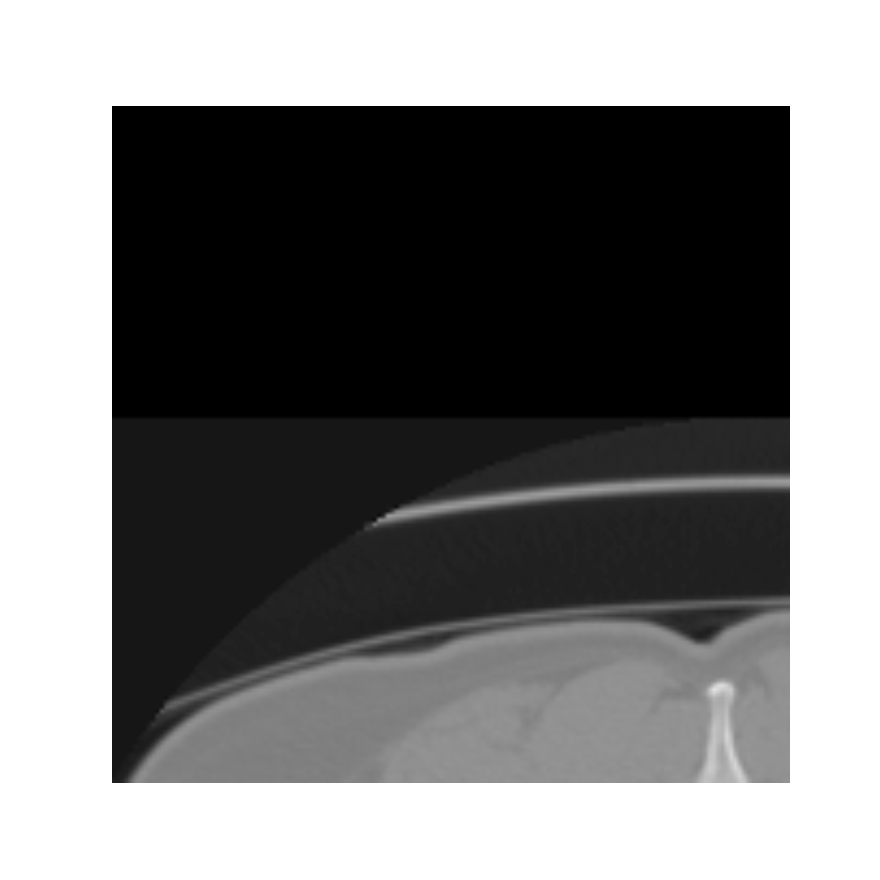

In [30]:
# get an image and a label from our train set
image = train_set.imgs[0]
label = train_set.lbls[0]

# test PatchExtractor
patch_size = (156, 156, 156)
patch_extractor = PatchExtractor(patch_size=patch_size, fromLiver=True)

# lets check some patches
patch, target = patch_extractor.get_patch(image, label)

print(patch.shape)
print(target.shape)

# show patch
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(patch.reshape(patch_size), view='axial', overlay_1=target.reshape(patch_size), overlay_1_thres=1, 
                   overlay_2=target.reshape(patch_size), overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

# Batch creator
Lets also reuse the batch creator from assignment 7. We are going to use valid convolutions, which means the output of our network will be smaller than the input. The purpose of this batchcreator is the make batches consisting of patches with their corresponding labels (for the network to train on). Since a UNet with valid convolutions has a smaller output than input, we need to crop the label based on the target size aswell. And labels should be in onehot.

In [31]:
class BatchCreator:
    
    def __init__(self, patch_extractor, dataset, target_size):
        self.patch_extractor = patch_extractor
        self.target_size = target_size # size of the output, can be useful when valid convolutions are used        
        self.imgs = dataset.imgs
        self.lbls = dataset.lbls                
        self.n = len(self.imgs)
        self.patch_size = self.patch_extractor.patch_size
    
    def create_image_batch(self, batch_size):
        '''
        returns a single (batch of?) patches (x) with corresponding labels (y) in one-hot structure
        '''
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 1))  # 1 channel
        y_data = np.zeros((batch_size, *self.target_size, 2)) # one-hot encoding with 2 classes
        
        for i in range(0, batch_size):
        
            random_index = np.random.choice(len(self.imgs))                   # pick random image
            img, lbl = self.imgs[random_index], self.lbls[random_index]       # get image and segmentation map
            
            # clip values outside [-1000, 3000] and normalize image intensity to range [0., 1.]      
            img = np.clip(img, -1000, 3000)
            img = (img - np.min(img)) / np.ptp(img)     
            
            # get a patch with corresponding labels from the patch extractor
            patch_img, patch_lbl = self.patch_extractor.get_patch(img, lbl)   
            
            # crop labels based on target_size           
            ph = (self.patch_extractor.patch_size[0] - self.target_size[0]) // 2    
            pw = (self.patch_extractor.patch_size[1] - self.target_size[1]) // 2
            pd = (self.patch_extractor.patch_size[2] - self.target_size[2]) // 2
            
            # take the cropped patch, it contains labels with values 0,1,2
            cropped_patch = patch_lbl[ph:ph+self.target_size[0], pw:pw+self.target_size[1], pd:pd+self.target_size[2]].squeeze()
            
            # instead of 0,1,2 label values we want categorical/onehot => 0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]
            onehot = to_categorical(cropped_patch, num_classes=2)
            
            x_data[i, :, :, :, :] = patch_img
            y_data[i, :, :, :, :] = onehot
        
        return (x_data.astype(np.float32), y_data.astype(np.float32))
    
    def get_image_generator(self, batch_size):
        '''returns a generator that will yield image-batches infinitely'''
        while True:
            yield self.create_image_batch(batch_size)

# 3D UNet Model
Start with this model, we can adapt this later if needed. Build like the net from: 
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.

In [32]:
# make block of two convolve3D's
def unet_block(inputs, n_filters, padding, up_conv=False, batchnorm=False):
    # 3d convolve, 32 3x3x3 filters 
    c1 = Conv3D(n_filters, (3,3,3), activation='relu', padding=padding)(inputs)
    if batchnorm:
        c1 = BatchNormalization()(c1)
    
    # up conv (normal conv in the expanding path) has same number of filters twice
    if up_conv:
        c2 = Conv3D(n_filters, (3, 3, 3), activation='relu', padding=padding)(c1)
    else:          # normal convs have twice the filters in the second conv
        c2 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', padding=padding)(c1)
        
    if batchnorm:
        c2 = BatchNormalization()(c2)
    
    return c2

In [33]:
# 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.
def build_unet_3d(initial_filters, padding, batchnorm=True, print_model=False):
    
    ## CONTRACTING PATH
    
    # (spac_dim_1, space_dim_2, space_dim_3, channels)
    inputs = Input(shape=(156, 156, 156, 1))

    # First conv pool, 32 filters and 64 filters    
    block_1    = unet_block(inputs, initial_filters, padding=padding, batchnorm=batchnorm) 
    max_pool_1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_1)  # 2×2×2 max pooling with strides two
                                                                        # needs even spacial_dimensions as input
    # second conv pool, 64 filters, 128 filters    
    block_2    = unet_block(max_pool_1, initial_filters*2, padding=padding, batchnorm=batchnorm)
    max_pool_2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_2)
    
    # third conv pool, 128 filters, 256 filters    
    block_3    = unet_block(max_pool_2, initial_filters*4, padding=padding, batchnorm=batchnorm)
    max_pool_3 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_3)
    
    # just a conv block without maxpooling, 256 filters and 512 filters
    conv_4     = unet_block(max_pool_3, initial_filters*8, padding=padding, batchnorm=batchnorm)
    
    ## EXPANDING PATH   
        
    # round 1
    up_conv_3  = Conv3DTranspose(16*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(conv_4)
    crop_3     = Cropping3D(cropping=4)(block_3) 
    concat_3   = concatenate([crop_3, up_conv_3])  
    up_block_3 = unet_block(concat_3, 8*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 2
    up_conv_2  = Conv3DTranspose(8*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_3) 
    crop_2     = Cropping3D(cropping=16)(block_2) 
    concat_2   = concatenate([crop_2, up_conv_2])  
    up_block_2 = unet_block(concat_2, 4*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 3
    up_conv_1  = Conv3DTranspose(4*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_2) 
    crop_1     = Cropping3D(cropping=40)(block_1) 
    concat_1   = concatenate([crop_1, up_conv_1])  
    up_block_1 = unet_block(concat_1, 2*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # finish with 1x1x1 conv, 3 filters, # labels, softmax or ReLU?
    finish = Conv3D(2, (1,1,1), activation='softmax', padding=padding)(up_block_1)
    
    model = Model(inputs, finish) 
    
    if print_model:
        print(model.summary(line_length=150))
    
    return model

In [34]:
unet_3d = build_unet_3d(initial_filters=32, padding='valid', batchnorm=False, print_model=True)

Instructions for updating:
Colocations handled automatically by placer.
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             (None, 156, 156, 156, 1)         0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 154, 154, 154, 32)        896               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv3d_2 (Conv3D)     

## Testing the batch generator

(batch, d, h, w, channels)
xdata has shape: (2, 156, 156, 156, 1)
ydata has shape: (2, 68, 68, 68, 2)
Occuring values in true labels: [ 0.  1.]
Min of input: 0.0
Max of input: 0.9307430982589722


<IPython.core.display.Javascript object>


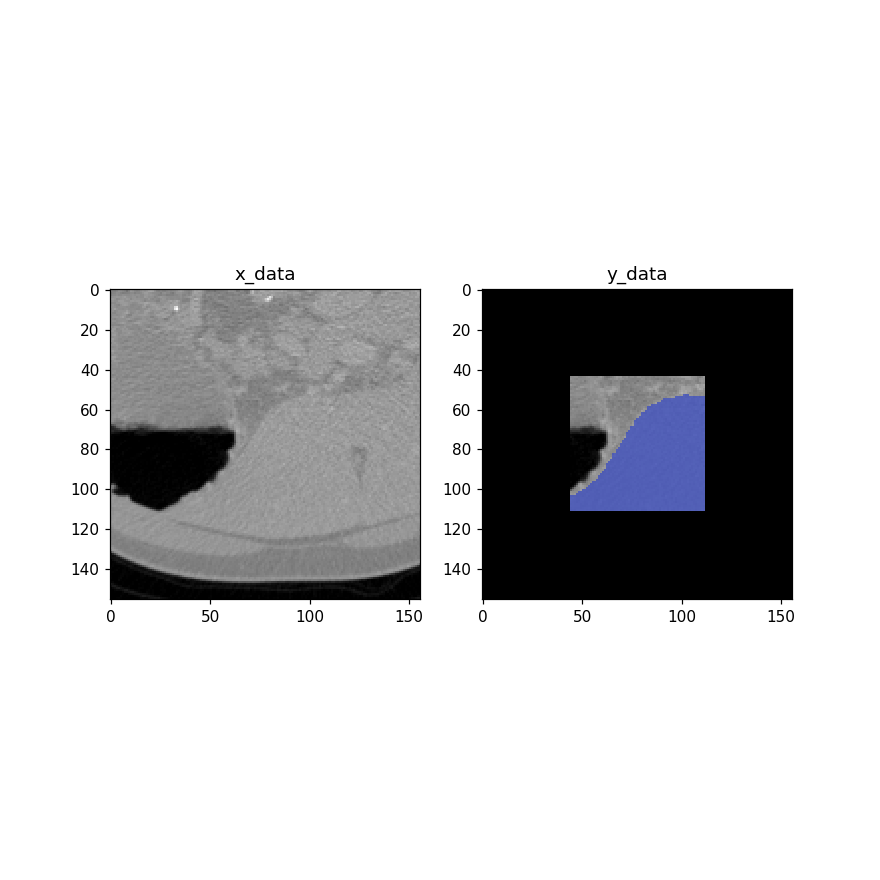

In [35]:
# define parameters for the batch creator
patch_size  = (156, 156, 156)  # isotropic patch size
target_size = (68, 68, 68)     # output size, smaller since valid convolutions are used
batch_size  = 2                # number of patches in a mini-batch, for segmentation 1 is fine, since the 
                               # output of the net is many thousands of values per patch, which all contribute to the loss

# initialize patch generator and batch creator
patch_generator       = PatchExtractor(patch_size, fromLiver=True)
batch_generator_train = BatchCreator(patch_generator, train_set, target_size=target_size)
batch_generator_val   = BatchCreator(patch_generator, val_set, target_size=target_size)

# get one minibatch
x_data, y_data = batch_generator_train.create_image_batch(batch_size)

print("(batch, d, h, w, channels)")
print('xdata has shape: {}'.format(x_data.shape))
print('ydata has shape: {}'.format(y_data.shape))
print('Occuring values in true labels: {}'.format(np.unique(y_data)))
print('Min of input: {}'.format(np.min(x_data)))
print('Max of input: {}'.format(np.max(x_data)))

# show the patches, to check the batchcreator, mid slice
x = patch_size[0] // 2
patch = x_data[0, x, :, :].squeeze()

# get labels from one hot
label = np.argmax(y_data[0, :, :, :], axis=-1)

# labels were cropped, so pad them
p = (patch_size[0] - target_size[0]) // 2
padded_lbl = np.pad(label, ((p, p), (p, p), (p, p)), 'constant', constant_values=3.)

# makes masks to plot label overlay
masked_crop = np.ma.masked_where(padded_lbl != 3, padded_lbl)
masked_lbl  = np.ma.masked_where(padded_lbl == 0, padded_lbl)

# take the mid slice aswell
masked_lbl  = masked_lbl[x, :, :]            
masked_crop = masked_crop[x, :, :]

# show x_data (no labels) and y_data, which are the labels for the center crop of x_data
# y_data is plotted with padding to check
plt.figure()
plt.subplot(1, 2, 1, title='x_data')
plt.imshow(patch, cmap='gray')
plt.subplot(1, 2, 2, title='y_data')
plt.imshow(patch, cmap='gray')
plt.imshow(masked_lbl, cmap='coolwarm', alpha = 0.75)
plt.imshow(masked_crop, cmap='gray', alpha = 1)
plt.show()

## Define a logger which saves the losses and saves the best model

In [36]:
class Logger(keras.callbacks.Callback):

    # logg losses, removed accs for now
    def __init__(self, data_dir, model_name, base_model):  
        self.model_filename = os.path.join(data_dir, model_name + '.h5')        
        self.tr_losses = []  
        self.val_losses = []      
        self.best_val_loss = float("inf")   
        self.base_model = base_model
       
    def on_epoch_end(self, batch, logs={}):
        # add validation info
        self.val_losses.append(logs.get('val_loss'))
        self.tr_losses.append(logs.get('loss'))
        self.plot()

        # safe best model after epoch end
        if self.val_losses[-1] < self.best_val_loss:
            self.best_val_loss = self.val_losses[-1]
            
            # call save on the base model instead of the parallel model, both models share the same weights
            self.base_model.save(self.model_filename) # save best model to disk
            print('Best model saved as {}'.format(self.model_filename))
         
    def plot(self): 
        clear_output()
        plt.figure(figsize=(8, 4))
        n = len(self.val_losses) + 1         
        plt.plot(range(1, n), self.tr_losses, label='train loss')         
        plt.plot(range(1, n), self.val_losses, label='val loss')        
        plt.legend(loc='lower left')
        plt.show()

In [37]:
# make a data dir to store best model
print(os.getcwd())
data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

/nfs/home4/mbotros/ISMI_project/Task03_Liver


## Dice Loss
Dice loss seems to be a good pick for 3D segmentation with class inbalances. (see https://arxiv.org/pdf/1707.03237.pdf)

**For binary volumes of N voxels (Milletari et al., 2016, VNet): http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf**

$$ \textbf{DL}_1 = 1 -\frac{2 \sum_{i}^{N} p_{i} g_{i}}{\sum_{i}^{N} p_{i}^{2}+\sum_{i}^{N} g_{i}^{2}} $$

In [38]:
# attempt to make a dice loss as above
def dice_loss(y_true, y_pred, epsilon=1e-6):
    '''  
    Dice loss calculation.
    Assumes the channels_last format.
    y_true: One hot encoding of ground truth
    y_pred: Network output, must sum to 1 over c channel (such as after softmax) 
    '''    
    # for every voxel of the prediction the probabililty of being foreground (liver) first axis = batch
    P = K.sum(y_pred * K.constant([0., 1.]), axis=-1)      # shape = (b, z, h, w)
                                                           #         (2, z, h ,w)
        
    # for every voxel of the groundtruth the label (0: background, 1: foreground), first axis = batch
    G = K.sum(y_true * K.constant([0., 1.]), axis=-1)      # shape = (b, z, h, w)
                                                           #         (2, z ,h ,w)
         
    # compute dice per patch
    nom   = 2. * K.sum(P * G, axis=(1, 2, 3))                               # shape = (2,)
    denom = K.sum(P**2., axis=(1, 2, 3)) + K.sum(G**2., axis=(1, 2, 3))     # shape = (2,)
    
    # return both dices from each patch in vec
    return 1 - (nom + epsilon) / (denom + epsilon)

$$
\textbf{DL}_{2}=1-\frac{\sum_{n=1}^{N} p_{n} r_{n}+\epsilon}{\sum_{n=1}^{N} p_{n}+r_{n}+\epsilon}-\frac{\sum_{n=1}^{N}\left(1-p_{n}\right)\left(1-r_{n}\right)+\epsilon}{\sum_{n=1}^{N} 2-p_{n}-r_{n}+\epsilon}
$$

Let R be the reference foreground segmentation (gold standard) with voxel values $r_n$, and P the predicted probabilistic map for the foreground label over N image elements $p_n$, with the background class probability being 1 − P. 

Sudre, Carole H., et al. "Generalised dice overlap as a deep learning loss function for highly unbalanced segmentations." https://arxiv.org/pdf/1707.03237.pdf

In [39]:
def dice_loss_2(y_true, y_pred, epsilon=1e-6):
    ''' 
    Dice loss calculation in a binary classification (foreground vs. background) formulation.
    Assumes the channels_last format.
    y_true: One hot encoding of ground truth
    y_pred: Network output, must sum to 1 over c channel (such as after softmax) 
    '''
    # for every voxel of the prediction the probabililty of being foreground (liver
    P = K.sum(y_pred * K.constant([0., 1.]), axis=-1)   # shape = (b, z, h, w)
    
    # for every voxel of the groundtruth the label (0: background, 1: foreground)
    R = K.sum(y_true * K.constant([0., 1.]), axis=-1)   # shape = (b, z, h, w)
    
    a = K.sum(P * R, axis=(1, 2, 3)) 
    b = K.sum(P + R, axis=(1, 2, 3)) + epsilon
    c = K.sum((1. - P) * (1. - R), axis=(1, 2, 3)) 
    d = K.sum((2. - P - R), axis=(1, 2, 3)) + epsilon
    
    return 1 - a/b - c/d

$$ \textbf{DL}_3 =  1 - \frac{2 \hspace{0.3em}|X \cap Y|}{|X|+ |Y|} $$

In [40]:
def dice_loss_3(y_true, y_pred, epsilon=1e-6):
    ''' 
    Dice loss calculation.
    y_true: One hot encoding of ground truth
    y_pred: Network output, must sum to 1 over c channel (such as after softmax) 
    '''
   # for every voxel of the prediction the probabililty of being foreground (liver
    P = K.sum(y_pred * K.constant([0., 1.]), axis=-1)   # shape = (b, z, h, w)
    
    # for every voxel of the groundtruth the label (0: background, 1: foreground)
    R = K.sum(y_true * K.constant([0., 1.]), axis=-1)   # shape = (b, z, h, w)
    
    #  |X| ∩ |Y|, true positives
    true_positives = K.sum(P * R, axis=(1, 2, 3))
    
    # this is |Y| number of voxels predicted to be fg (probabilities) no
    fg_voxels_p = K.sum(P, axis=(1, 2, 3))
    
    # this is |X|, should be the number of foreground voxels
    fg_voxels_r = K.sum(R, axis=(1, 2, 3))
    
    return 1. - (2. * true_positives + epsilon) / (fg_voxels_r + fg_voxels_p + epsilon)

## Testing loss functions

In [43]:
# test this loss function
loss_function = dice_loss_2

# all zeros and all ones in one hot        
all_bg = np.ones(shape=(2, 68, 68, 68, 2)) * [1, 0]
all_fg = np.ones(shape=(2, 68, 68, 68, 2)) * [0, 1]

# some fg in patch 1
some_fg  = np.copy(all_bg)
some_fg2 = np.copy(all_bg)
some_fg[0, :34, :34, :34]  = [0, 1]
some_fg2[0, :17, :17, :17] = [0, 1]

print('A bit of fg, predicts exactly that bit of fg:{}'.format(loss_function(some_fg, some_fg).eval(session=sess)))
print('A bit of fg, predicts exactly half of that bit of fg:{}'.format(loss_function(some_fg, some_fg2).eval(session=sess)))

print('All is bg, predicts all fg: {}'.format(loss_function(all_bg, all_fg).eval(session=sess)))
print('All is fg, predicts all bg: {}'.format(loss_function(all_fg, all_bg).eval(session=sess)))

print('Complete overlap in both patches fg: {}'.format(loss_function(all_fg, all_fg).eval(session=sess)))
print('Complete overlap in both patches bg: {}'.format(loss_function(all_bg, all_bg).eval(session=sess)))

A bit of fg, predicts exactly that bit of fg:[ 0.   0.5]
A bit of fg, predicts exactly half of that bit of fg:[ 0.41830066  0.5       ]
All is bg, predicts all fg: [ 1.  1.]
All is fg, predicts all bg: [ 1.  1.]
Complete overlap in both patches fg: [ 0.5  0.5]
Complete overlap in both patches bg: [ 0.5  0.5]


In [44]:
# the patch we are training with
a, y_true = batch_generator_train.create_image_batch(batch_size=batch_size)
all_bg    = np.ones(shape=(2, 68, 68, 68, 2)) * [1., 0.]        

print('The patch we are training with, prediction of all bg:{}'.format(loss_function(y_true, all_bg).eval(session=sess)))
print('The patch we are training with, perfect prediction:{}'.format(loss_function(y_true, y_true).eval(session=sess)))

The patch we are training with, prediction of all bg:[ 0.74081087  0.66265547]
The patch we are training with, perfect prediction:[ 0.  0.]


## Getting class weights
Instead of computing class weights from the whole train set, we might want to compute if from the batch in which we sample patches from the liver. This changes the foreground/background ratio.

In [45]:
# maybe we want class weight based on the fg/bg ratio in the patches
def compute_weights_from_batch(batch_gen, batch_size):
    # create a batch of batch_size
    x_data, y_data = batch_gen.create_image_batch(batch_size=batch_size)
    print(y_data.shape)
    
    labels = np.argmax(y_data, axis=-1)
    print(labels.shape)
    
    l, counts = np.unique(labels, return_counts=True)
    print(l)
    print(counts) 
    
    # inverse of volume
    return 1 / counts

In [46]:
weights_from_batch = compute_weights_from_batch(batch_generator_train, batch_size=25)
print('Class weights from batch: {}'.format(weights_from_batch))

(25, 68, 68, 68, 2)
(25, 68, 68, 68)
[0 1]
[4086206 3774594]
Class weights from batch: [  2.44725792e-07   2.64929155e-07]


**Do we need class weights? The occurence of foreground and background is not that unbalanced for when we extract patches from the liver with a probability of 0.7.**

## Now we define parameters, compile the model and train the network 

In [47]:
# build model
unet_3d = build_unet_3d(initial_filters=32, padding='valid', batchnorm=False, print_model=False)

# parameters
learning_rate   = 3*10**-4
optimizer       = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
steps_per_epoch = 50
epochs          = 50
batch_size      = 2
logger          = Logger(data_dir, 'test-02-06v2', base_model=unet_3d)

# get generators
image_generator_train = batch_generator_train.get_image_generator(batch_size)
image_generator_val   = batch_generator_val.get_image_generator(batch_size)

# compile model
parallel_model = multi_gpu_model(unet_3d, gpus=2)                   # batchsize should be a multiple of #gpu's
parallel_model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [48]:
# back to inline, I don't know how to plot in notebook mode
%matplotlib inline

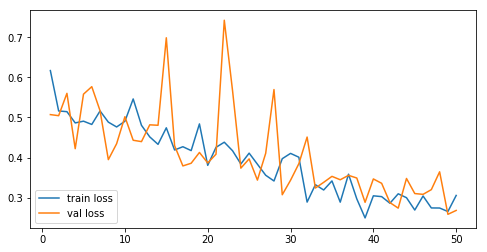

In [49]:
# train the model
parallel_model.fit_generator(generator=image_generator_train, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=image_generator_val,                  
                    verbose=1,
                    validation_steps=25,
                    callbacks=[logger])

## Getting the full segmentation map
Like this but then 3D:

![seg_diagram.png](seg_diagram.png)


In [50]:
def padding(image, patch_size, target_size):
    """
    Adding the red border (see example above) to the image. Which is needed for when we don't have full context. 
    Pad with lowest occuring values.
    image       : the input image (as numpy)
    patch_size  : patch_size of the input for the UNet
    target_size : output size of the model, needed to calculate how much to padd in each dimension. 
    """
    z, y, x = patch_size
    
    # pad with min value from image, always safe
    min_val = np.min(image)
    
    # size of padding for each dimension
    pad_z = (z - target_size[0]) // 2
    pad_x = (x - target_size[1]) // 2
    pad_y = (y - target_size[2]) // 2
    
    # pad with a tuple for how much on each side for every dimension
    padded_input = np.pad(image, ((pad_z, pad_z), (pad_x, pad_x), (pad_y, pad_y)), 'constant', constant_values=min_val)
    
    return padded_input

In [51]:
def predict_image_segmentation(model, image, target_size, patch_size):
    """
    Give a full segmentation map (same size as input_image) using the model. 
    model       : the model to do the prediction
    image       : the input image (as numpy)
    target_size : output size of the model (since we use valid convutions the output gets smaller)
    patch_size: : the size of the patch that is put into the model
    """
    
    # clip values outside [-1000, 3000] and normalize image intensity to range [0., 1.]      
    image = np.clip(image, -1000, 3000)
    image = (image - np.min(image)) / np.ptp(image)    
    
    # pad the input image:
    pad_img = padding(image, patch_size, target_size)  

    print("Image size: {}".format(image.shape))
    print("Padded image size: {}".format(pad_img.shape))
    
    dims = image.shape
    # how many times target size fits in a dimension 
    pz = dims[0] // target_size[0] 
    px = dims[1] // target_size[1] 
    py = dims[2] // target_size[2] 
    
    # segmentation map, same size as input image
    segmentation = np.zeros(image.shape)   
    
    for z in range(pz, -1, -1):         
        for x in range(px, -1, -1):
            for y in range(py, -1, -1):  
                
                # shift starting point with target_size
                start_z = z * target_size[0]
                start_x = x * target_size[1]
                start_y = y * target_size[2]
                
                # if the patch does not fit:
                if start_z + patch_size[0] > pad_img.shape[0]:
                    start_z = pad_img.shape[0] - patch_size[0]
                if start_x + patch_size[1] > pad_img.shape[1]:
                    start_x = pad_img.shape[1] - patch_size[1]
                if start_y + patch_size[2] > pad_img.shape[2]:
                    start_y = pad_img.shape[2] - patch_size[2]
                
                # Get patch: shift with target_size, take patch_size                
                patch = pad_img[start_z:start_z + patch_size[0], 
                                start_x:start_x + patch_size[1], 
                                start_y:start_y + patch_size[2]]     

                # Reshape for u-net and make prediction:
                patch = np.reshape(patch, (1, patch_size[0], patch_size[1], patch_size[2], 1))
                prediction = model.predict(patch)

                # Put the prediction in segmentation map, shift with target_size, take target_size
                segmentation[start_z:start_z + target_size[0], 
                             start_x:start_x + target_size[1], 
                             start_y:start_y + target_size[2]] = np.argmax(np.squeeze(prediction), axis=3)
    
    return segmentation 

## Inspecting the prediction

In [52]:
# take image of validation set
image = val_set.imgs[0]
label = val_set.lbls[0]

print(image.shape)
print(label.shape)

(588, 351, 351)
(588, 351, 351)


In [53]:
# load best model
unet_3d = load_model(os.path.join(data_dir, 'test-02-06v2' + '.h5'))

In [54]:
# predict the segmentation map
segmentation = predict_image_segmentation(unet_3d, image, target_size, patch_size)

Image size: (588, 351, 351)
Padded image size: (676, 439, 439)


In [58]:
print(np.unique(segmentation, return_counts=True))
print(np.unique(label, return_counts=True))

(array([ 0.,  1.]), array([70720864,  1721324]))
(array([0, 1], dtype=uint8), array([71013899,  1428289]))


In [56]:
%matplotlib notebook

In [57]:
# plot slices
def compare_with_groundtruth(image, label, segmentation, slice_nr=None):
    
    # mid slice
    s = image.shape[0] // 2
    
    # or a given slice 
    if slice_nr:
        s = slice_nr
        
    slice_img = image[s, :, :]
    slice_lbl = label[s, :, :]
    slice_seg = segmentation[s, :, :]

    # masks for plotting the label overlay
    masked_lbl = np.ma.masked_where(slice_lbl < 1, slice_lbl)
    masked_seg = np.ma.masked_where(slice_seg < 1, slice_seg)

    plt.figure()
    plt.subplot(1,2,1).set_title('Prediction')
    plt.imshow(slice_img, cmap='gray')
    if (np.any(masked_seg)):
        plt.imshow(masked_seg, cmap='coolwarm', alpha = 0.75)

    plt.subplot(1,2,2).set_title('Ground truth')
    plt.imshow(slice_img, cmap='gray')
    if (np.any(masked_lbl)):
        plt.imshow(masked_lbl, cmap='coolwarm', alpha = 0.75)
    plt.show()

<IPython.core.display.Javascript object>


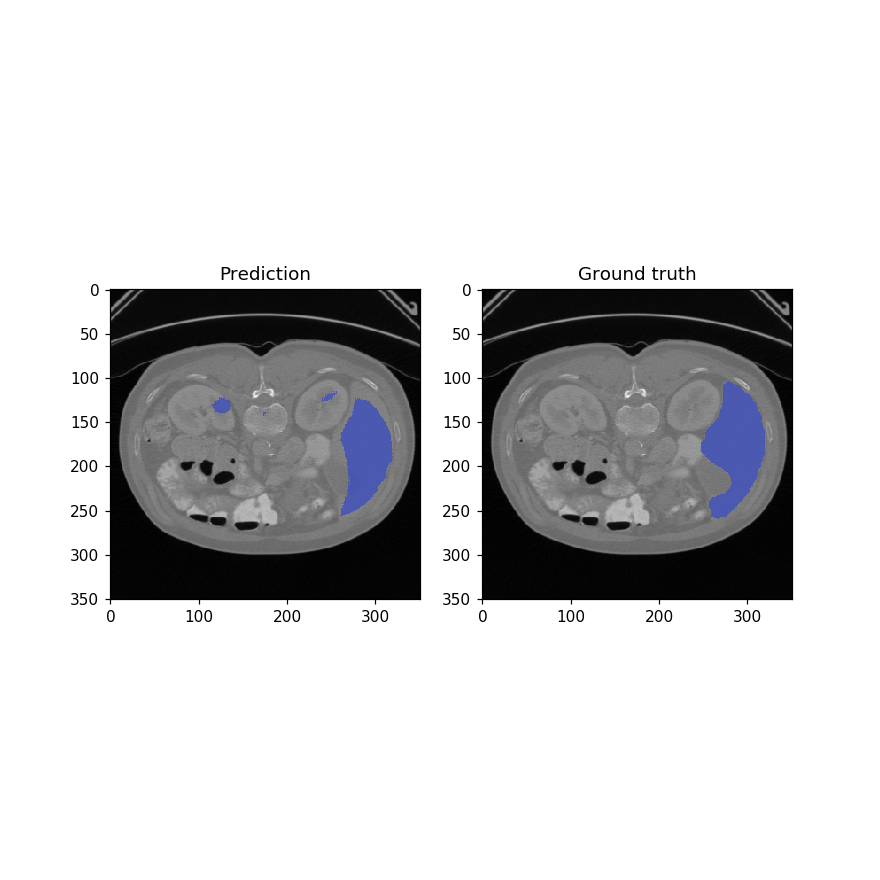

In [59]:
compare_with_groundtruth(image, label, segmentation, slice_nr=300)

<IPython.core.display.Javascript object>


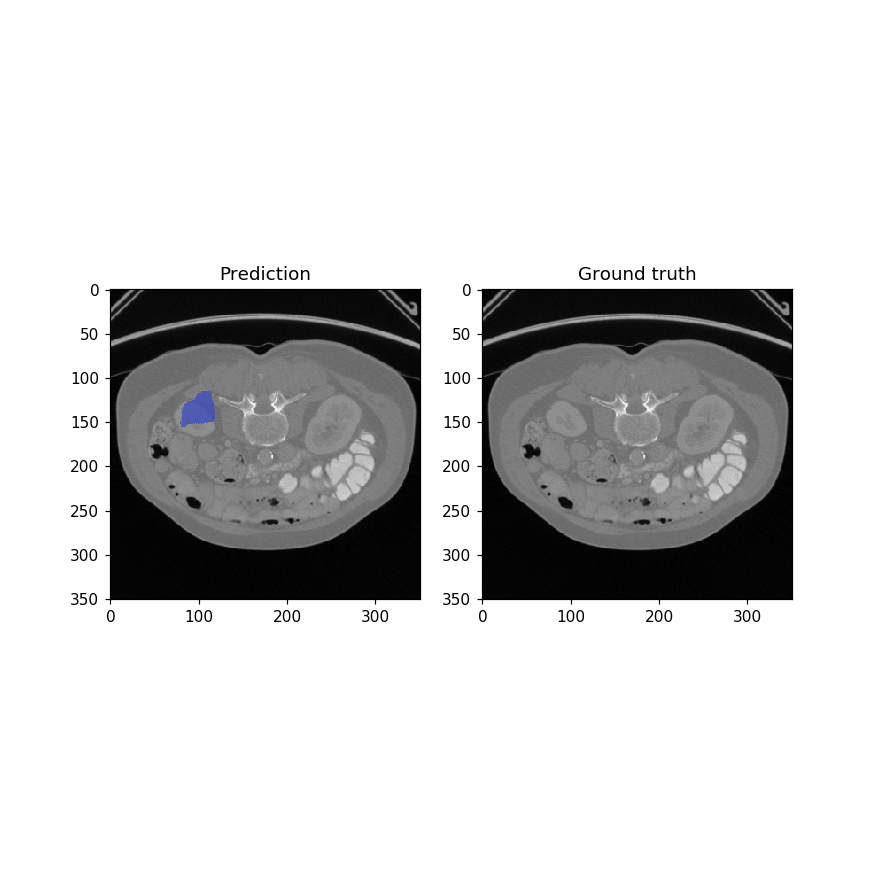

In [64]:
compare_with_groundtruth(image, label, segmentation, slice_nr=250)

<IPython.core.display.Javascript object>


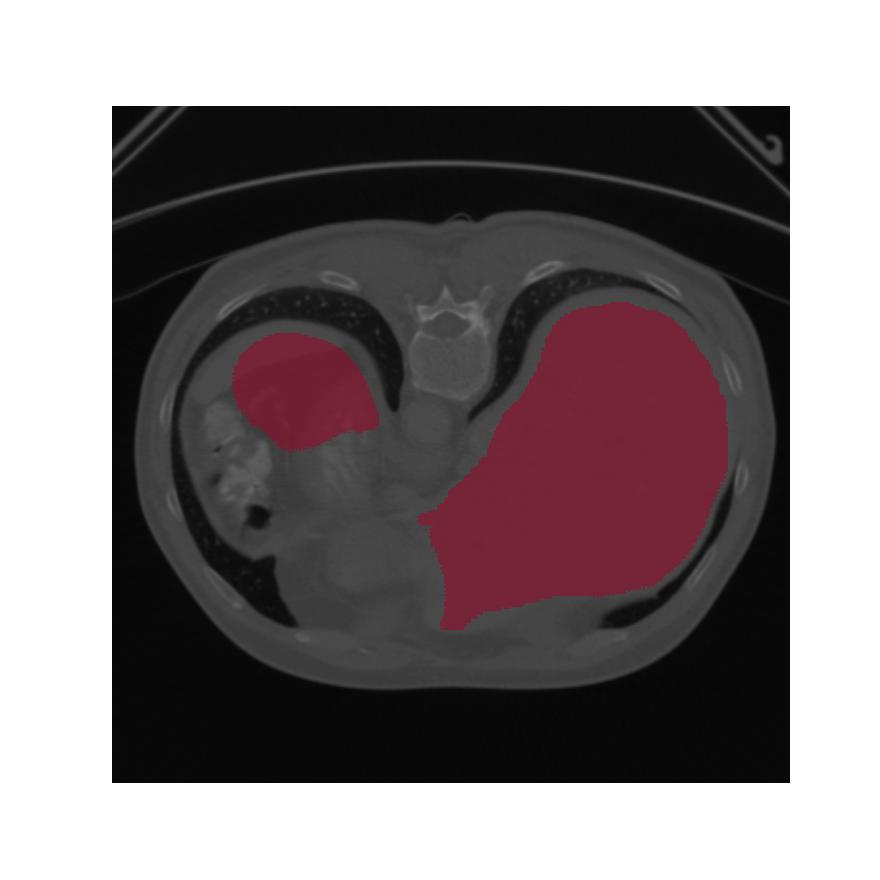

In [65]:
# show segmentation
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(image, view='axial', overlay_1=segmentation, overlay_1_thres=1, 
                   overlay_2=segmentation, overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

In [ ]:
# show ground truth
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(image, view='axial', overlay_1=label, overlay_1_thres=1, 
                   overlay_2=label, overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)